In [ ]:
! pip install scikit-plot

In [ ]:
import os
import cv2
import math
import joblib
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, ZeroPadding2D, MaxPool2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, concatenate
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

In [ ]:
DATA_PATH = "/kaggle/input/fyp-dataset/feraligned/feraligned/"
TOP_EMOTIONS = ["Angry", "Fear", "Happy", "Neutral", "Sadness"]

TRAIN_SIZE = 0.80
INPUT_SHAPE = (64,64,1)
NUM_CLASSES = len(TOP_EMOTIONS)

In [ ]:
total_images = 0
for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        count = 0
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            count += 1
        print(f"{dir_} has {count} number of images")
        total_images += count

print(f"\ntotal images are {total_images}")

Fear has 552 number of images
Angry has 633 number of images
Neutral has 863 number of images
Sadness has 904 number of images
Happy has 1577 number of images

total images are 4529


In [ ]:
img_arr = []
img_label = []
label_to_text = {}
label = 0

for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            img = cv2.imread(DATA_PATH + dir_ + "/" + f, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (64, 64))  # Resize the image to 64x64
            img_arr.append(np.expand_dims(img, axis=2))
            img_label.append(label)
        print(f"loaded {dir_} images to numpy arrays...")
        label_to_text[label] = dir_
        label += 1

img_arr = np.array(img_arr)
img_label = np.array(img_label)
img_label = OneHotEncoder(sparse=False).fit_transform(img_label.reshape(-1, 1))

img_arr.shape, img_label.shape, label_to_text

loaded Fear images to numpy arrays...
loaded Angry images to numpy arrays...
loaded Neutral images to numpy arrays...
loaded Sadness images to numpy arrays...
loaded Happy images to numpy arrays...


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((4529, 64, 64, 1),
 (4529, 5),
 {0: 'Fear', 1: 'Angry', 2: 'Neutral', 3: 'Sadness', 4: 'Happy'})

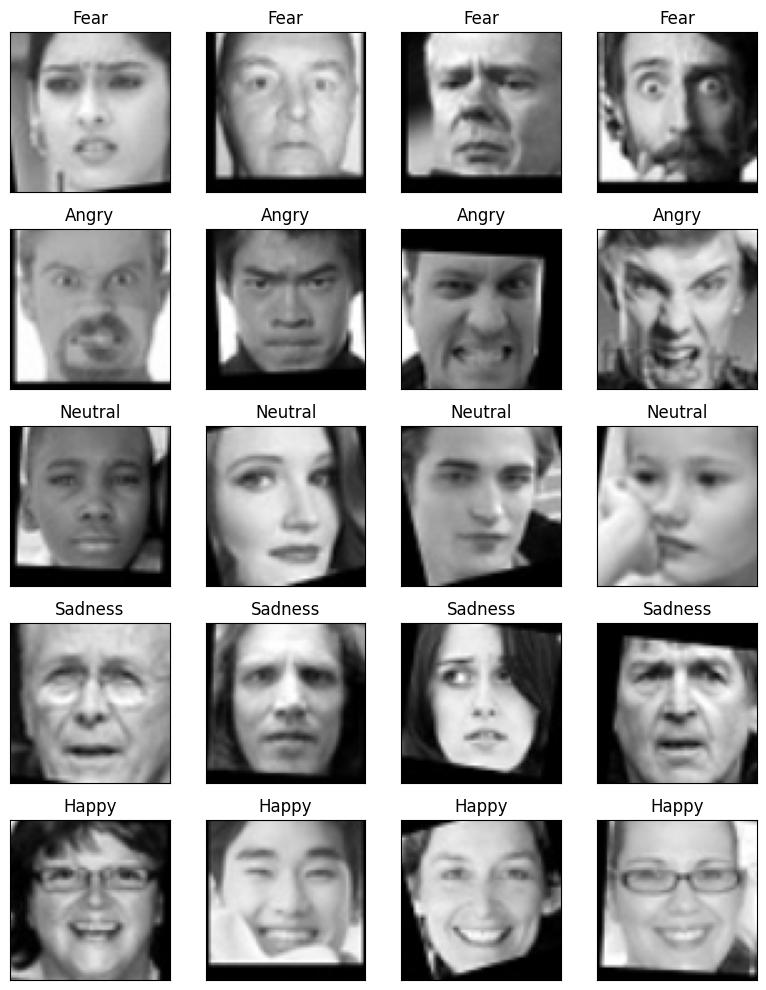

In [ ]:
num_emotions = len(TOP_EMOTIONS)
num_cols = 4
fig, axes = pyplot.subplots(num_emotions, num_cols, figsize=(num_cols*2, num_emotions*2))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label[:, k] == 1)[0], size=num_cols, replace=False)
    sample_images = img_arr[sample_indices]

    for i, img in enumerate(sample_images):
        ax = axes[idx, i]
        ax.imshow(img.reshape(64, 64), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])

    idx += 1

pyplot.tight_layout()
pyplot.show()

In [ ]:
img_arr = img_arr / 255.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=TRAIN_SIZE, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3623, 64, 64, 1), (906, 64, 64, 1), (3623, 5), (906, 5))

In [ ]:
def inception_block(X,
                    filters_1x1: int,
                    filters_3x3_reduce: int,
                    filters_3x3: int,
                    filters_5x5_reduce: int,
                    filters_5x5: int,
                    filters_pool_proj: int,
                    block_name: str):

    conv_1x1 = Conv2D(
            filters=filters_1x1,
            kernel_size=(1, 1),
            padding='same',
            activation='relu',
            kernel_initializer=he_normal(seed=42),
            name=f"incepblock{block_name}_conv_1x1",
        )(X)

    conv_3x3_reduce = Conv2D(
            filters=filters_3x3_reduce,
            kernel_size=(1, 1),
            padding='same',
            activation='relu',
            kernel_initializer=he_normal(seed=42),
            name=f"incepblock{block_name}_conv_3x3_reduce",
        )(X)
    conv_3x3 = Conv2D(
            filters=filters_3x3,
            kernel_size=(3,3),
            padding='same',
            activation='relu',
            kernel_initializer=he_normal(seed=42),
            name=f"incepblock{block_name}_conv_3x3",
        )(conv_3x3_reduce)

    conv_5x5_reduce = Conv2D(
            filters=filters_5x5_reduce,
            kernel_size=(1, 1),
            padding='same',
            activation='relu',
            kernel_initializer=he_normal(seed=42),
            name=f"incepblock{block_name}_conv_5x5_reduce",
        )(X)
    conv_5x5 = Conv2D(
            filters=filters_5x5,
            kernel_size=(5,5),
            padding='same',
            activation='relu',
            kernel_initializer=he_normal(seed=42),
            name=f"incepblock{block_name}_conv_5x5",
        )(conv_5x5_reduce)

    pool_proj = MaxPool2D(
        pool_size=(3, 3),
        strides=(1, 1),
        padding='same',
        name=f"incepblock{block_name}_maxpool",
    )(X)
    conv_after_pool = Conv2D(
            filters=filters_pool_proj,
            kernel_size=(1, 1),
            padding='same',
            activation='relu',
            kernel_initializer=he_normal(seed=42),
            name=f"incepblock{block_name}_conv_afterpool",
        )(pool_proj)

    concated = concatenate([conv_1x1, conv_3x3, conv_5x5, conv_after_pool], axis=3, name=f"incepblock{block_name}_concat")
    return concated

In [ ]:
def auxiliary_block(X, out_shape: int, block_id: int):
    X = AveragePooling2D(
        pool_size=(3,3),
        strides=(1,1),
        padding='valid',
        name=f"auxblock{block_id}_avgpool",
    )(X)

    X = Conv2D(
            filters=128,
            kernel_size=(1,1),
            strides=(1,1),
            padding='same',
            activation='relu',
            name=f"auxblock{block_id}_conv2d",
    )(X)

    X = Flatten(name=f"auxblock{block_id}_flatten",)(X)

    X = Dense(units=128, activation='relu', name=f"auxblock{block_id}_dense1",)(X)

    X = Dropout(0.25, name=f"auxblock{block_id}_dropout",)(X)

    X = Dense(units=out_shape, activation='softmax', name=f"auxblock{block_id}_outlayer",)(X)
    return X

In [ ]:
def InceptionNet(in_shape, out_shape, show_summary=False):
    "shallow inception-net without auxiliary layers"

    model_in = Input(shape=in_shape, name="in_layer")

    X = Conv2D(
            filters=32,
            kernel_size=(3,3),
            padding='same',
            strides=(1,1),
            activation='relu',
            kernel_initializer=he_normal(seed=42)
        )(model_in)
    X = Conv2D(
            filters=64,
            kernel_size=(1,1),
            padding='same',
            strides=(1,1),
            activation='relu',
            kernel_initializer=he_normal(seed=42)
        )(X)

    X = MaxPool2D(
        (3, 3),
        padding='same',
        strides=(2, 2),
        )(X)

    X = inception_block(X,
            filters_1x1=64,
            filters_3x3_reduce=96,
            filters_3x3=128,
            filters_5x5_reduce=16,
            filters_5x5=32,
            filters_pool_proj=32,
            block_name='1a'
    )
    X = inception_block(X,
            filters_1x1=128,
            filters_3x3_reduce=128,
            filters_3x3=192,
            filters_5x5_reduce=32,
            filters_5x5=96,
            filters_pool_proj=64,
            block_name='1b'
    )

    X = MaxPool2D(
        (3, 3),
        padding='same',
        strides=(2, 2),
        )(X)

    X = inception_block(
        X,
        filters_1x1=192,
        filters_3x3_reduce=96,
        filters_3x3=208,
        filters_5x5_reduce=16,
        filters_5x5=48,
        filters_pool_proj=64,
        block_name='2a'
    )
    X = inception_block(
        X,
        filters_1x1=160,
        filters_3x3_reduce=112,
        filters_3x3=224,
        filters_5x5_reduce=24,
        filters_5x5=64,
        filters_pool_proj=64,
        block_name='2b'
    )

    X = MaxPool2D(
        (3, 3),
        padding='same',
        strides=(2, 2),
        )(X)

    X = inception_block(
        X,
        filters_1x1=256,
        filters_3x3_reduce=160,
        filters_3x3=320,
        filters_5x5_reduce=32,
        filters_5x5=128,
        filters_pool_proj=128,
        block_name='3a'
    )
    X = inception_block(
        X,
        filters_1x1=384,
        filters_3x3_reduce=192,
        filters_3x3=384,
        filters_5x5_reduce=48,
        filters_5x5=128,
        filters_pool_proj=128,
        block_name='3b'
    )

    X = GlobalAveragePooling2D()(X)

    X = Dense(128, activation='relu')(X)
    X = Dropout(0.25)(X)

    model_out = Dense(out_shape, activation="softmax", name="out_layer")(X)

    model = Model(model_in, model_out, name="InceptionNet")

    if show_summary:
        model.summary()

    return model

In [ ]:
# Define a custom callback for early stopping based on validation accuracy
class CustomEarlyStopping(Callback):
    def __init__(self, monitor='val_accuracy', patience=10, restore_best_weights=True):
        super(CustomEarlyStopping, self).__init__()
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best = -np.Inf  # Initialize best to negative infinity
        self.best_epoch = 0
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        current_val_acc = logs.get(self.monitor)
        if current_val_acc > self.best:
            self.best = current_val_acc
            self.best_epoch = epoch
            self.best_weights = self.model.get_weights()  # Save the best weights
        elif epoch - self.best_epoch >= self.patience:
            print(f"Epoch {epoch}: Early stopping due to no improvement in {self.patience} epochs.")
            self.model.stop_training = True
            if self.restore_best_weights and self.best_weights is not None:
                print(f"Restoring best weights from epoch {self.best_epoch}.")
                self.model.set_weights(self.best_weights)

In [ ]:
model = InceptionNet(INPUT_SHAPE, NUM_CLASSES, show_summary=True)

Model: "InceptionNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 in_layer (InputLayer)       [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 32)           320       ['in_layer[0][0]']            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           2112      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                    

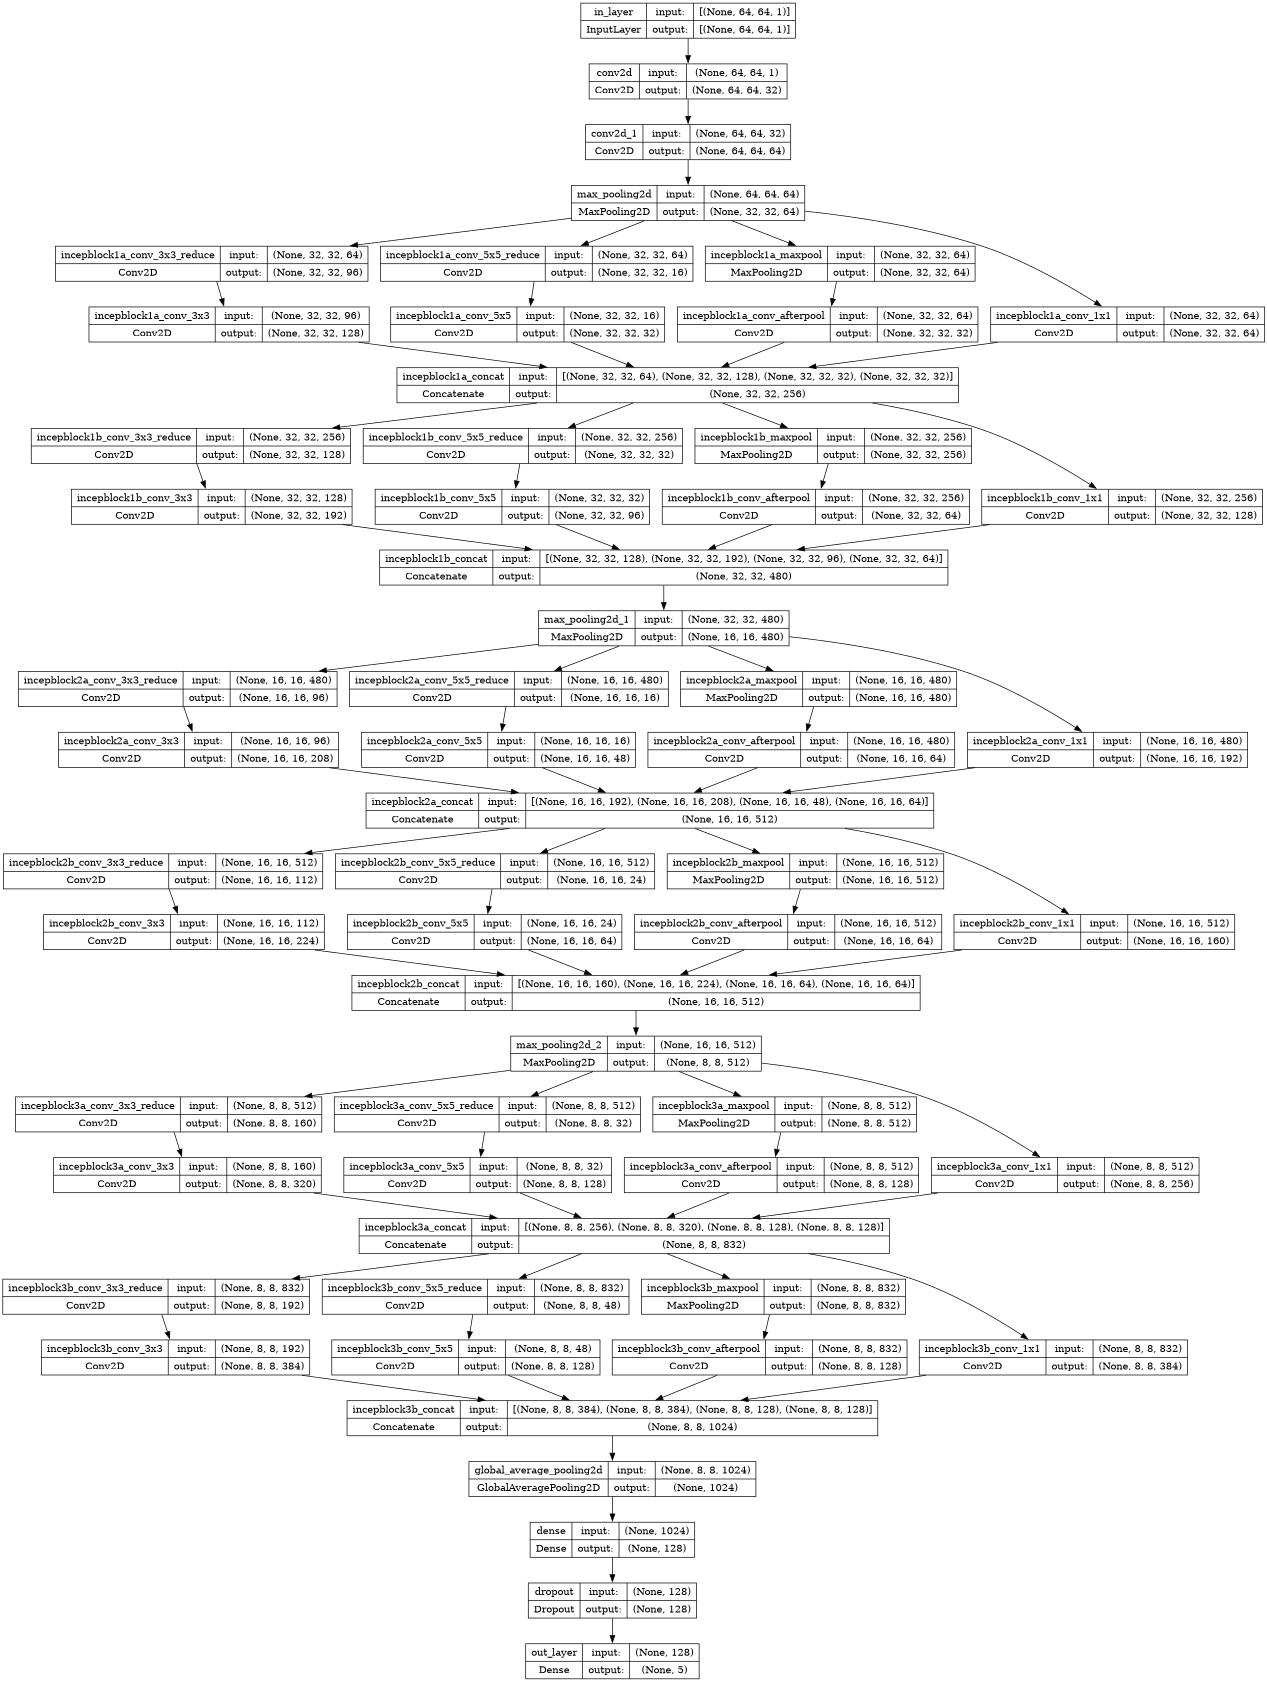

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50,)

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.1,
    horizontal_flip=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    min_delta=0.0001,
    factor=0.1,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0005,
    patience=13,
    verbose=1,
    restore_best_weights=True,
)

In [ ]:
batch_size = 32
loss = "categorical_crossentropy"
optim = optimizers.Adam(0.001)
epochs = 100

In [ ]:
model.compile(
        loss=loss,
        optimizer=optim,
        metrics=['accuracy'],
)

train_datagen.fit(X_train)

custom_early_stopping = CustomEarlyStopping(patience=15)

history_InceptionNet = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data = (X_test, y_test),
    steps_per_epoch = len(X_train) / batch_size,
    epochs = epochs,
    callbacks = [lr_scheduler, custom_early_stopping],
)

Epoch 1/100
113/113 [==============================] - 30s 89ms/step - loss: 1.6070 - accuracy: 0.3403 - val_loss: 1.5425 - val_accuracy: 0.3477 - lr: 0.0010
Epoch 2/100
113/113 [==============================] - 7s 60ms/step - loss: 1.5470 - accuracy: 0.3486 - val_loss: 1.5359 - val_accuracy: 0.3477 - lr: 0.0010
Epoch 3/100
113/113 [==============================] - 7s 60ms/step - loss: 1.5413 - accuracy: 0.3489 - val_loss: 1.5303 - val_accuracy: 0.3477 - lr: 0.0010
Epoch 4/100
113/113 [==============================] - 7s 61ms/step - loss: 1.5423 - accuracy: 0.3464 - val_loss: 1.5241 - val_accuracy: 0.3477 - lr: 0.0010
Epoch 5/100
113/113 [==============================] - 7s 61ms/step - loss: 1.5334 - accuracy: 0.3497 - val_loss: 1.5320 - val_accuracy: 0.3477 - lr: 0.0010
Epoch 6/100
113/113 [==============================] - 7s 61ms/step - loss: 1.5258 - accuracy: 0.3450 - val_loss: 1.5054 - val_accuracy: 0.3477 - lr: 0.0010
Epoch 7/100
113/113 [==============================] - 7s

In [ ]:
history = pd.DataFrame(history_InceptionNet.history)
history

,loss,accuracy,val_loss,val_accuracy,lr
0,1.606951,0.340326,1.542534,0.347682,1.000000e-03
1,1.546951,0.348606,1.535903,0.347682,1.000000e-03
2,1.541271,0.348882,1.530302,0.347682,1.000000e-03
3,1.542343,0.346398,1.524130,0.347682,1.000000e-03
4,1.533414,0.349710,1.531986,0.347682,1.000000e-03
5,1.525805,0.345018,1.505404,0.347682,1.000000e-03
6,1.524449,0.348606,1.513819,0.347682,1.000000e-03
7,1.505365,0.348882,1.471119,0.363135,1.000000e-03
8,1.474346,0.365443,1.502147,0.342163,1.000000e-03
9,1.448329,0.374275,1.412781,0.381898,1.000000e-03


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

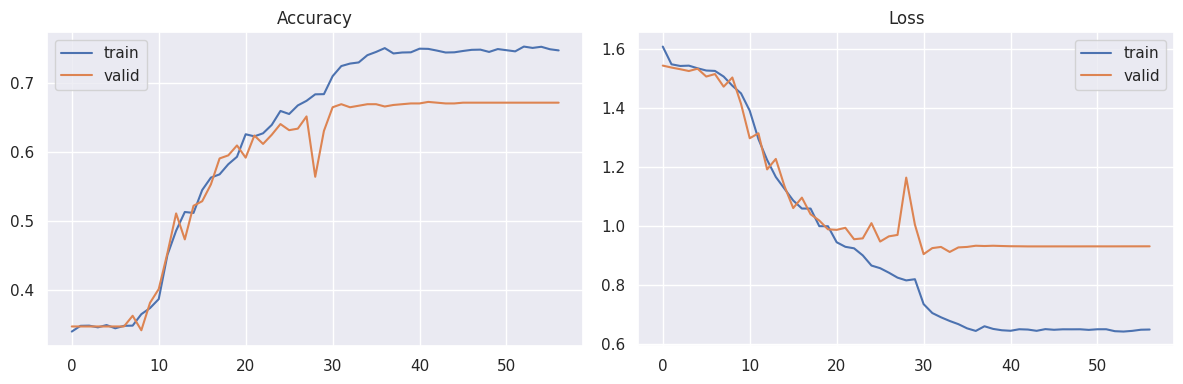

In [ ]:
sns.set()
fig = pyplot.figure(figsize=(12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history_InceptionNet.epoch, y=history_InceptionNet.history['accuracy'], label='train')
sns.lineplot(x=history_InceptionNet.epoch, y=history_InceptionNet.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history_InceptionNet.epoch, y=history_InceptionNet.history['loss'], label='train')
sns.lineplot(x=history_InceptionNet.epoch, y=history_InceptionNet.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.show()

In [ ]:
label_to_text

{0: 'Fear', 1: 'Angry', 2: 'Neutral', 3: 'Sadness', 4: 'Happy'}

114/114 - 2s - loss: 0.6048 - accuracy: 0.7635 - 2s/epoch - 19ms/step

train Accuracy: 0.7634556889533997
29/29 - 1s - loss: 0.9301 - accuracy: 0.6722 - 548ms/epoch - 19ms/step

Test Accuracy: 0.6721854209899902
29/29 [==============================] - 1s 18ms/step

Classification Report:
               precision    recall  f1-score   support

       Angry       0.70      0.55      0.61       110
        Fear       0.62      0.73      0.67       127
       Happy       0.53      0.55      0.54       173
     Neutral       0.50      0.54      0.52       181
     Sadness       0.89      0.83      0.86       315

    accuracy                           0.67       906
   macro avg       0.65      0.64      0.64       906
weighted avg       0.68      0.67      0.68       906



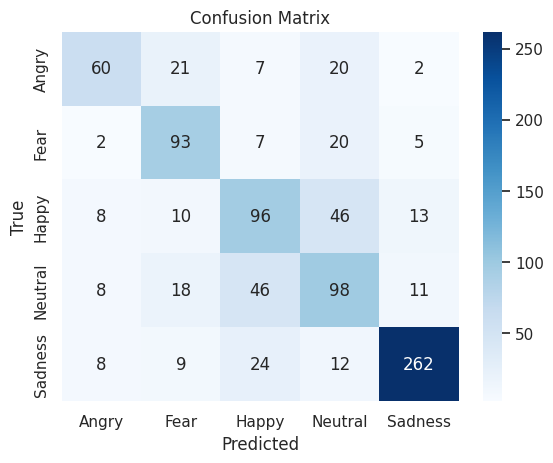

In [ ]:
from sklearn.metrics import confusion_matrix

# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=2)
print(f"\ntrain Accuracy: {train_acc}")

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest Accuracy: {test_acc}")

# Predictions
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Classification Report
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels, target_names=TOP_EMOTIONS))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=TOP_EMOTIONS, yticklabels=TOP_EMOTIONS)
pyplot.title('Confusion Matrix')
pyplot.xlabel('Predicted')
pyplot.ylabel('True')
pyplot.show()

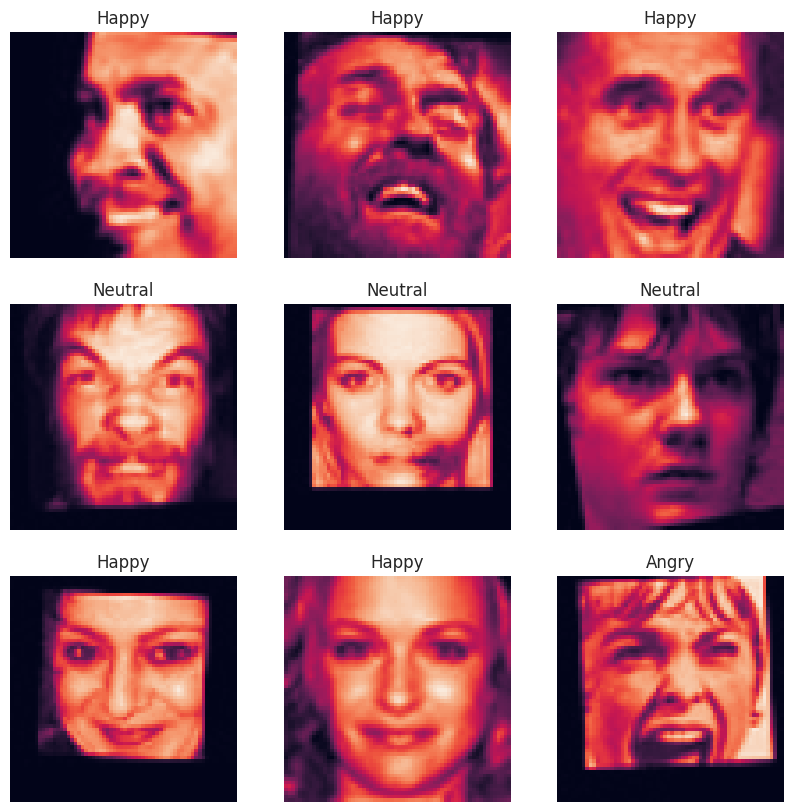

In [ ]:
# Visualize some predictions
pyplot.figure(figsize=(10, 10))
for i in range(9):
    ax = pyplot.subplot(3, 3, i + 1)
    pyplot.imshow(X_test[i])
    pyplot.title(label_to_text[predicted_labels[i]])
    pyplot.axis("off")

pyplot.show()

In [ ]:
pip install visualkeras

  Obtaining dependency information for visualkeras from https://files.pythonhosted.org/packages/a5/93/abd375b37add77d58a8c48a506ae39bb77c4380e2507ea444325ff1b9971/visualkeras-0.0.2-py3-none-any.whl.metadata
  Obtaining dependency information for aggdraw>=1.3.11 from https://files.pythonhosted.org/packages/e4/57/59b42e145ff12941c5c63d59dc48369912a9e29d69966ff630e6f0f815ac/aggdraw-1.3.18.post0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 4.7 MB/s eta 0:00:0000:0100:01m
Note: you may need to restart the kernel to use updated packages.


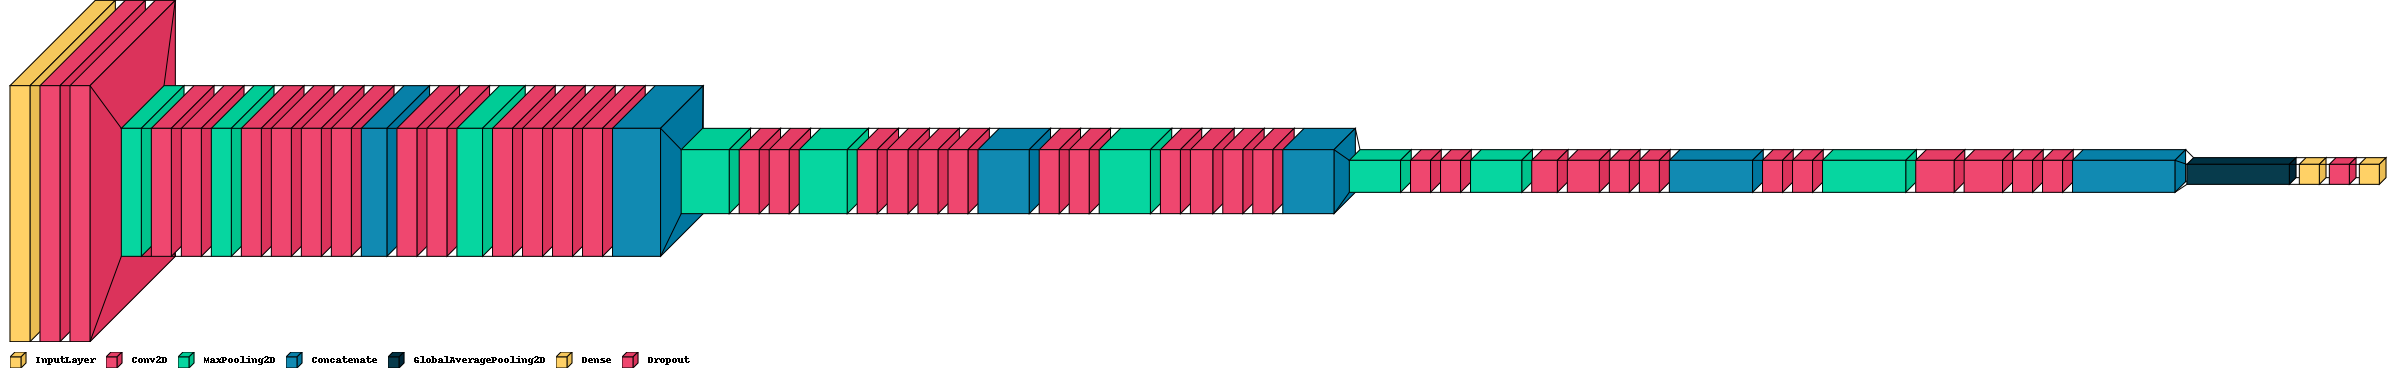

In [ ]:
import visualkeras

visualkeras.layered_view(model, legend=True)